In [230]:
import numpy as np
import yfinance as yf

<h2>Getting stock data</h2>

In [231]:
def make_stock_df(symbol):
    tickerData = yf.Ticker(symbol)
    #get the historical prices for this ticker
    tickerDf = tickerData.history(period='1d', start='2010-1-1')
    dow = tickerDf.index.day_of_week
    data = tickerDf[["Close", "Volume"]]
    data.insert(1, 'Date_Week', dow)
    return data

In [232]:
def get_yahoo_stock_data(symbol, columns=None, dfrom='2020-1-1'):
    tickerData = yf.Ticker(symbol)
    tickerDf = tickerData.history(period='1d', start='2010-1-1')
    tickerDf["Date_Week"] = tickerDf.index.day_of_week
    targetDf = tickerDf if columns is None else tickerDf[columns]
    return targetDf

In [234]:
# ["Date_Week", "Open", "High", "Low", "Close", "Volume"]
TSM_df = get_yahoo_stock_data("TSM", columns=None, dfrom='2010-1-1')
TSM_df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Date_Week
Date,,,,,,,,
2010-01-04 00:00:00-05:00,7.5867,7.7187,7.5735,7.6461,8096400,0.0,0,0
2010-01-05 00:00:00-05:00,7.6593,7.6989,7.5669,7.6131,14375900,0.0,0,1
2010-01-06 00:00:00-05:00,7.6329,7.6659,7.5140,7.5867,13608400,0.0,0,2
2010-01-07 00:00:00-05:00,7.5338,7.5537,7.3094,7.3358,27346600,0.0,0,3
2010-01-08 00:00:00-05:00,7.3556,7.4084,7.2829,7.3292,16895300,0.0,0,4
...,...,...,...,...,...,...,...,...
2022-09-28 00:00:00-04:00,71.1100,72.2900,70.7000,72.1300,12943600,0.0,0,2
2022-09-29 00:00:00-04:00,70.5200,70.6800,68.4800,69.2800,16120300,0.0,0,3
2022-09-30 00:00:00-04:00,67.8100,69.6500,67.7400,68.5600,10463200,0.0,0,4


<AxesSubplot:xlabel='Date'>

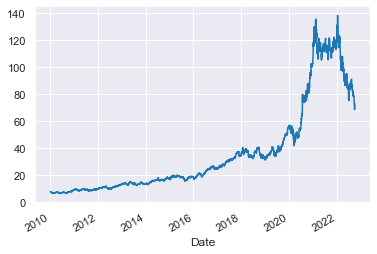

In [229]:
TSM_df.Close.plot()

<h3>Features Engineering</h3>